In [1]:
import pandas as pd
import numpy as np 
import sklearn as sk 
from hmmlearn import hmm
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.ndimage.interpolation import shift
from datetime import date, timedelta, datetime
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import scipy.stats

### Signal Generation Functions

In [2]:
def counter(pred, prev_pred, count, threshold):
    if pred == prev_pred:
            count = count + 1 
            
    elif pred != prev_pred:
        count = 1
        
    
        
    return count

def generate_signal_rolling(start, end, X, states, window, threshold0, threshold1, seed):
    np.random.seed(seed)
    signal = []
    count0 = 0
    count1 = 0
    reverse = False
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[start-window:start])
    predictions = model.predict(X[start-window:start])
    
    pred0 = 0
    pred1 = 1
    
    num_zeros = (predictions == 0).sum()
    num_ones = (predictions == 1).sum()
    
    if num_zeros > num_ones:
        reverse = True
        print(reverse)
    
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[start-window+i:start+i])
        predictions = model.predict(X[start-window+i:start+i])
        pred = predictions[-1]
        
        
        # thresh0
        if count0 >= threshold0:
            if pred == 0:
                signal.append(0)
                count0 = count0 + 1
                count1 = 0
            elif pred == 1:
                signal.append(signal[-1])
                count0 = 0
                count1 = count1 + 1   
        elif count0 < threshold0:
            if pred == 0:
                count0 = count0 + 1
                count1 = 0
                signal.append(signal[-1])
            elif pred == 1:
                count0 = 0
                count1 = count1 + 1
                
        # thresh1
        if count1 >= threshold1:
            if pred == 0:
                signal.append(signal[-1])
                count1 = 0
                count0 = count0 + 1
            elif pred == 1:
                signal.append(1) 
                count1 = count1 + 1
                count0 = 0
        elif count1 < threshold1:
            if pred == 0:
                count1 = 0
                count0 = count0 + 1
            elif pred == 1:
                signal.append(signal[-1])
                count1 = count1 + 1
                count0 = 0
                
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

In [320]:
# calling function
signal = generate_signal_rolling(start, end, X, states, window, 33, 7, 22)
len(signal)

758

In [309]:
end-start

756

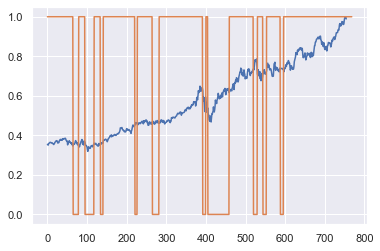

In [315]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change().dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
window = 1008
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_rolling(start, end, X, states, window, 7, 7, 22)

plt.plot(msft[start+1:end]["Open"].values/max(msft[start+1:end]["Open"]))
plt.plot(signal)

In [3]:
def generate_signal_rolling(start, end, X, states, window, delay, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[start-window:start])
    predictions = model.predict(X[start-window:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[start-window+i:start+i])
        predictions = model.predict(X[start-window+i:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= delay:
            signal.append(pred)
            
        elif count < delay:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

def generate_signal_expanding(start, end, X, states, threshold, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[:start])
    predictions = model.predict(X[:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[:start+i])
        predictions = model.predict(X[:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= threshold:
            signal.append(pred)
            
        elif count < threshold:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

### Cash Back-test Function

In [4]:
def backtest_signal(price, signal):
    w = np.zeros(np.shape(price))
    cash = np.zeros(np.shape(price))
    cash[0] = 10000

    for i in range(0, len(price)):

        if i == len(price)-1:
            break

        if signal[i] == 1: 
            w[i+1] = cash[i]/price[i]  + w[i]
            cash[i+1] = 0

        elif signal[i] == 0:
            cash[i+1] = w[i]*price[i] + cash[i]
            w[i+1] = 0
            
    strat = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]
    
    return strat

### Performance Ratios Functions

In [5]:
def log_returns(strat):
    returns = np.log(shift(strat, -1)/strat)
    returns = np.delete(returns, -1)
    return returns

def sharpe(returns):
    sharpe_ratio = np.mean(returns)/np.std(returns)
    return np.round(sharpe_ratio * np.sqrt(252), 3)

def sortino(returns):
    downside_returns = [ret for ret in returns if ret < 0]
    std = np.std(downside_returns)
    sortino = np.mean(returns)/std
    return np.round(sortino * np.sqrt(252), 3)

def max_dd(data):
    p = np.argmax(np.maximum.accumulate(data) - data)
    q = np.argmax(data[:p])
    max_drawdown = (data[p]-data[q])/data[q]
    return np.round(abs(max_drawdown), 3)

def calmar(returns, strat):
    drawdown = max_dd(strat)
    calmar = np.sqrt(252) * np.mean(returns)/drawdown
    return np.round(calmar, 3) 

def absolute_return(price):
    abs_ret = (price[-1] - price[0])/price[0]
    annual_abs_ret = abs_ret/(len(price)/252)
    return annual_abs_ret

def print_ann_ret(strat, price):
    print("Strategy Annualised Return:", round(absolute_return(strat),3), sep='\n')
    print("Asset Annualised Return:", round(absolute_return(price.values),3), sep='\n')

def print_ratios(strategy, price):
    print("Strategy:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(strat)),
    sortino(log_returns(strat)),
    calmar(log_returns(strat), strat))
    print("Asset:\nSharpe | Sortino | Calmar Ratios")
    print(
    sharpe(log_returns(price.values)),
    sortino(log_returns(price.values)),
    calmar(log_returns(price.values), price.values))
    print("\n")
    
def plot_highlighted_graph(price, threshold, string):
    values, ids = dc(price, threshold)

    d = []

    for i in range(1, len(idx)-1):
        if signal[i] == signal[i+1]:
            pass
        else:
            d.append(idx[i])

    d.append(idx[-1])

    plt.figure(figsize=(12,4))
    plt.title("Long (green) and Short (red) Regions of Price Output by HMM Model: Rolling Window", fontsize=18)
    plt.ylabel("Price", fontsize=18)
    plt.xlabel("Date", fontsize=18)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.plot(idx[0:-1], price)
    plt.xticks(rotation=45)
    plt.scatter(idx[ids], values, s=200, c='r')

    if signal[0] == 1:
        plt.axvspan(idx[0], d[0], facecolor='g', alpha=0.5)  
        for i in range(0, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='r', alpha=0.5)
        for i in range(1, len(d)-1, 2):
            plt.axvspan(d[i], d[i+1], facecolor='g', alpha=0.5)
    plt.tight_layout()
    #plt.grid()
    plt.savefig(string)
    plt.show() 

### DC Points Functions

In [6]:
def dc(price, threshold):

    curr_min = price[0]
    curr_min_id = 0
    curr_max = price[0]
    curr_max_id = 0
    min_bool = False
    max_bool = False

    values = []
    ids = []

    for i in range(1, len(price)):


        if price[i] > curr_max:
            curr_max = price[i]
            curr_max_id = i


        elif price[i] < curr_min:
            curr_min = price[i]
            curr_min_id = i


        if abs((price[i] - curr_min)/curr_min) >= threshold and min_bool == False:
            # save values and now look for OS point
            values.append(curr_min)
            ids.append(curr_min_id)

            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            min_bool = True
            max_bool = False

        elif abs((price[i] - curr_max)/curr_max) >= threshold and max_bool == False:
            # save values and now look for OS point
            values.append(curr_max)
            ids.append(curr_max_id)
            values.append(price[i])
            ids.append(i)

            # reset min and max points
            curr_min = price[i]
            curr_min_id = i
            curr_max = price[i]
            curr_max_id = i
            max_bool = True
            min_bool = False


    if min_bool == True:
        values.append(curr_max)
        ids.append(curr_max_id)
        
    elif max_bool == True:
        values.append(curr_min)
        ids.append(curr_min_id)
    

    return values, ids

## Results for Rolling Window Back-Test
- 2 states
- 4 year rolling window
- 7 day delay

In [89]:
#one = X

ret_list = [[one[i]] for i in range(0, len(one))]

vol_list = [[float(vol[i])] for i in range(0, len(vol))]

X = np.concatenate([ret_list, vol_list])

lengths = [len(ret_list), len(vol_list)]

In [101]:
# preparing data for returns and volatility inputs
ret = msft["Returns"].values
vol = msft["Vol"].values
X = vol

X = np.concatenate([ret, vol])

X

array([0.00409333, 0.00736477, 0.00324957, ..., 0.00493596, 0.00503371,
       0.0054127 ])

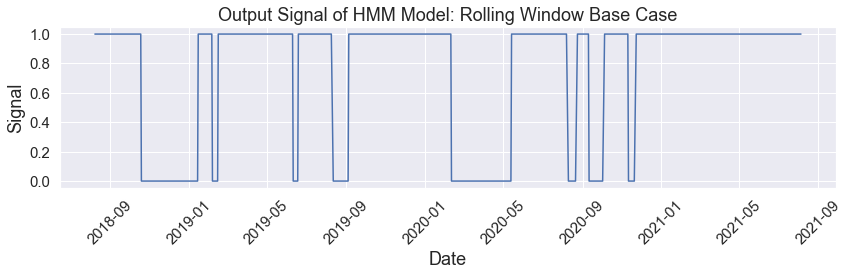

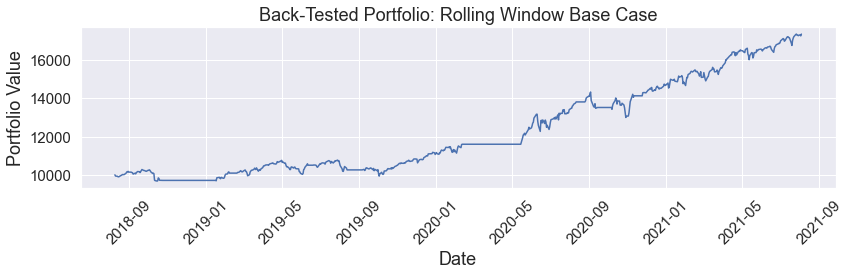

Strategy:
Sharpe | Sortino | Calmar Ratios
1.622 1.829 0.125
Asset:
Sharpe | Sortino | Calmar Ratios
0.808 0.925 0.028


Strategy Annualised Return:
0.247
Asset Annualised Return:
0.182


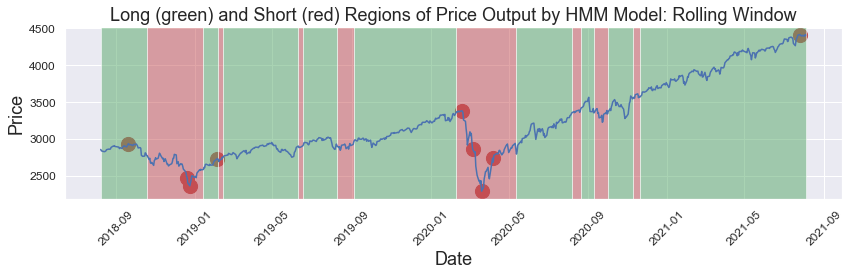

In [112]:
sns.set()

# importing the data
ticker = yf.Ticker('^GSPC')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change().dropna()
msft = msft.dropna()
msft["Vol"] = msft["Returns"].rolling(5).std()
msft = msft.dropna()

# initialising function parameters
start = 3017
end = len(msft)
#X = log_returns(msft["Close"].values)




window = 1008
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_rolling(start, end, X, states, window, delay, 22)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Rolling Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("S&P w delay (5) ret+vol Rolling Window signal base result")
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Rolling Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("S&P w delay (5) ret+vol Rolling Window portfolio backtest base result")
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, "S&P w delay (5) ret+vol Rolling window base result performance")

## Results for Expanding Window Back-Test (same Paramters)

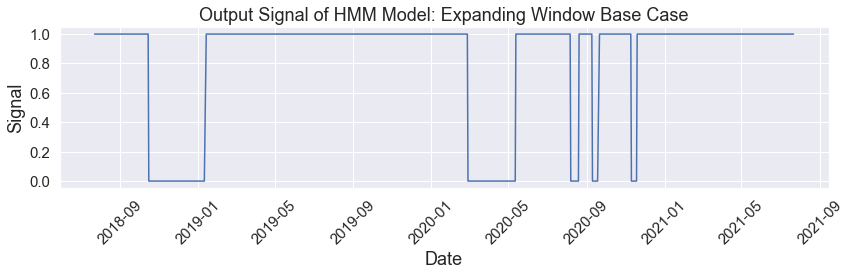

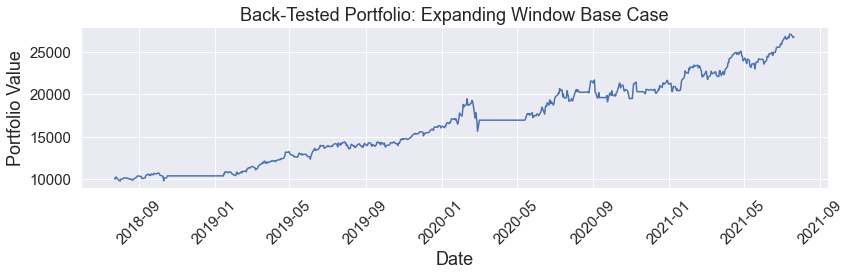

Strategy:
Sharpe | Sortino | Calmar Ratios
1.49 1.811 0.105
Asset:
Sharpe | Sortino | Calmar Ratios
1.197 1.57 0.075


Strategy Annualised Return:
0.563
Asset Annualised Return:
0.573


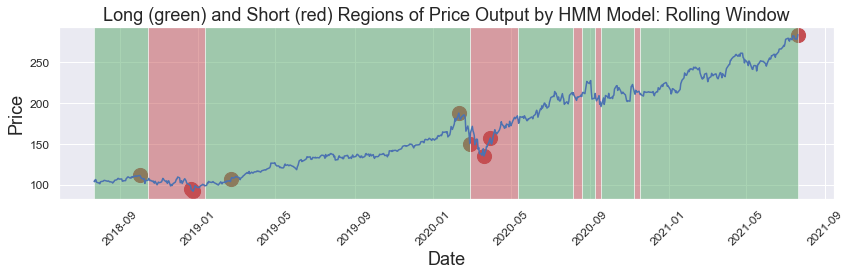

In [53]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal = generate_signal_expanding(start, end, X, states, delay, 2200)

# plotting signal 
idx = msft.index[start:]
plt.figure(figsize=(12,4))
plt.title("Output Signal of HMM Model: Expanding Window Base Case", fontsize=18)
plt.ylabel("Signal", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Expanding Window signal base result")
plt.show()

# back-testing signal
strat = backtest_signal(price, signal)

# plotting back-tested portfolio
plt.figure(figsize=(12,4))
plt.title("Back-Tested Portfolio: Expanding Window Base Case", fontsize=18)
plt.ylabel("Portfolio Value", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Expanding Window portfolio backtest base result")
plt.show()

# printing performance ratios
print_ratios(strat, price)

# print annualised returns
print_ann_ret(strat, price)

# plotting long and short graph
plot_highlighted_graph(price, threshold, "expanding window base result performance")

In [139]:
from scipy.stats import norm

def ret_df(signal, returns):
    df = pd.DataFrame()
    df["Returns"] = returns
    df["Signal"] = signal
    return df

def ret_norm_params(var):
    params = norm.fit(var)
    mean = params[0]
    std_dev = params[1]
    return mean, std_dev

def switch_signal(signal):
    signal = list(signal)
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        return signal
    else: 
        signal = np.array(signal)
        return signal
    
def normal_dist(x, mu, std):
    p = (1/np.sqrt(2*np.pi*std**2)) * np.exp(-((x-mu)**2)/2*std**2)
    return p

In [158]:
def NBC(predictions, X):
    # making sure more 1's than 0's
    predictions = switch_signal(predictions)
    predictions = predictions
    
    # calculating probability of either regime historically
    p_C0 = list(predictions).count(0)/len(predictions)
    p_C1 = list(predictions).count(1)/len(predictions)
    
    # returning df with returns and the signal
    df = ret_df(predictions, X)
    
    # obtaining returns from both states
    returns_0_state = df[df["Signal"] == 0]["Returns"]
    returns_1_state = df[df["Signal"] == 1]["Returns"]
    
    # fitting returns from both states to obtain parameters
    mean_0, std_0 = ret_norm_params(returns_0_state)
    mean_1, std_1 = ret_norm_params(returns_1_state)
    
    # fitting most recent return value to both distributions
    x = X[-1]
    px_C0 = normal_dist(x, mean_0, std_0)
    px_C1 = normal_dist(x, mean_1, std_1)
    
    # calculating the probability of the data
    px = px_C0*p_C0 + px_C1*p_C1
    
    # final output
    pC0_x = (p_C0*px_C0)/px
    pC1_x = (p_C1*px_C1)/px
    probabilities = [pC0_x, pC1_x]
    
    return probabilities

0 dist:  -0.001293998513368849 0.03237092608230151
1 dist:  0.0008273895548229504 0.013799933090847838
-0.015093395807610025 12.324091055801885 28.90900036590871
100
100


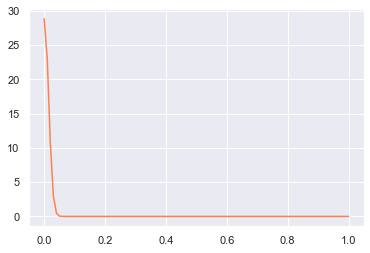

In [214]:
ret_df(predictions, X[:start])
returns_0_state = df[df["Signal"] == 0]["Returns"]
returns_1_state = df[df["Signal"] == 1]["Returns"]

mean_0, std_0 = ret_norm_params(returns_0_state)
mean_1, std_1 = ret_norm_params(returns_1_state)

x = X[-1]
px_C0 = normal_dist(x, mean_0, std_0)
px_C1 = normal_dist(x, mean_1, std_1)

print("0 dist: ", mean_0, std_0)
print("1 dist: ", mean_1, std_1)
print(x, px_C0, px_C1)


x_min = 0.0
x_max = 1
x = np.linspace(x_min, x_max, 100)
y_0 = scipy.stats.norm.pdf(x,mean_0,std_0)
y_1 = scipy.stats.norm.pdf(x,mean_1,std_1)

norm_y0 = y_0/max(y_0)
norm_y1 = y_1/max(y_1)

plt.plot(x,y_1, color='coral')

y0 = [y for y in y_0 if y > 1e-207]

print(len(np.sort(y0)))
print(len(np.sort(y_1)))

In [164]:
def generate_signal_expanding_w_NBC(start, end, X, states, delay, seed):
    np.random.seed(seed)
    signal = []
    count = 0
    NBC_count = 0
    NBC_preds = []
    X_reshape = X.reshape(-1, 1)
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X_reshape[:start])
    predictions = model.predict(X_reshape[:start])
    
    p = NBC(predictions, X[:start])
    NBC_preds.append((p, predictions[-1]))
    
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X_reshape[:start+i])
        predictions = model.predict(X_reshape[:start+i])
        pred = predictions[-1]
        
        p = NBC(predictions, X[:start+i])
        NBC_preds.append((p, pred))
        
        signal.append(pred)

        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal, NBC_count, NBC_preds

In [165]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
msft = msft.dropna()

# initialising function parameters
start = len(msft) - 756
end = len(msft)
X = log_returns(msft["Close"].values)
delay = 5
states = 2
price = msft[start+1:end]["Open"]
threshold = 0.15

# calling function
signal, nc, ncp = generate_signal_expanding_w_NBC(start, end, X, states, delay, 2200)

In [157]:
signal

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,